# Experiments

In [39]:
import torch
import numpy as np
import coupling_bound as cb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from pathlib import Path

In [40]:
cmaps = {
    "diverging": "bwr",
    "standard": "viridis"
}

markersize = 1
markerscale = 8

fig_width = 12
fig_dir = Path.cwd() / "figs"
fig_dir.mkdir(exist_ok=True)

## Data

In [41]:
dataset_root = Path.cwd() / "data"

## Loss development over many layers

Idea: Sample $N$ initial rotations per case.

In [42]:
# for name, sources in datasets:
dim = 48
N_vary = 64
sources = cb.data.build_dataset(dim, N_vary, 1e-3, 1e3, False, True)

In [43]:
ev = torch.cat(list(sources.values()), 0).numpy()
ev = ev / ev.mean(-1, keepdims=True)

Text(0.5, 0, 'Initital non-Standardness $\\mathcal{S}$')

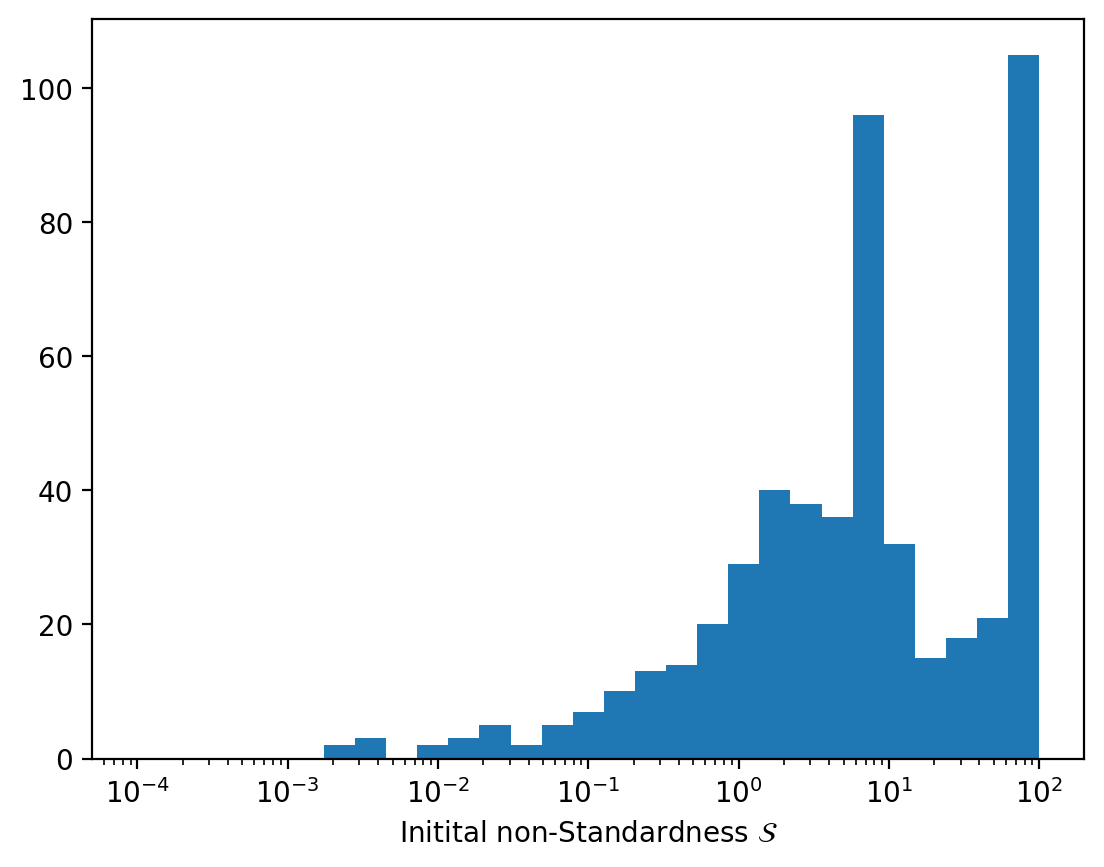

In [44]:
loss = cb.compute_non_standardness(ev)
plt.hist(loss, bins=np.geomspace(1e-4, 100, 30))
plt.xscale("log")
plt.xlabel(r"Initital non-Standardness $\mathcal{S}$")

In [45]:
dim = ev.shape[-1]
dim_a = dim // 2
dim_p = dim // 2

In [46]:
rot_count = 16
rot, rot_I = cb.empiric.sample_rot(dim, rot_count, cb.empiric.MODE_O)

In [47]:
torch.set_num_threads(2)

In [48]:
dim_a = dim // 2

cov0 = torch.diag_embed(torch.from_numpy(ev))[:, None]
cov0_ = rot[None] @ cov0 @ rot_I[None]
covs = [cov0_]

cov_last_ = cov0_
for _ in tqdm(range(32)):
    rotl, rotl_I = cb.empiric.sample_rot(dim, cov_last_.shape[1], cb.empiric.MODE_O)
    covl = rotl[None] @ cov_last_ @ rotl_I[None]
    covl_ = cb.empiric.apply_layer(dim_a, covl, s=True, t=True, sp=True)
    covs.append(covl_)

    cov_last_ = covl_

# Case, rotation, layer, dim, dim
covs = torch.stack(covs, 2).numpy()

  0%|          | 0/32 [00:00<?, ?it/s]

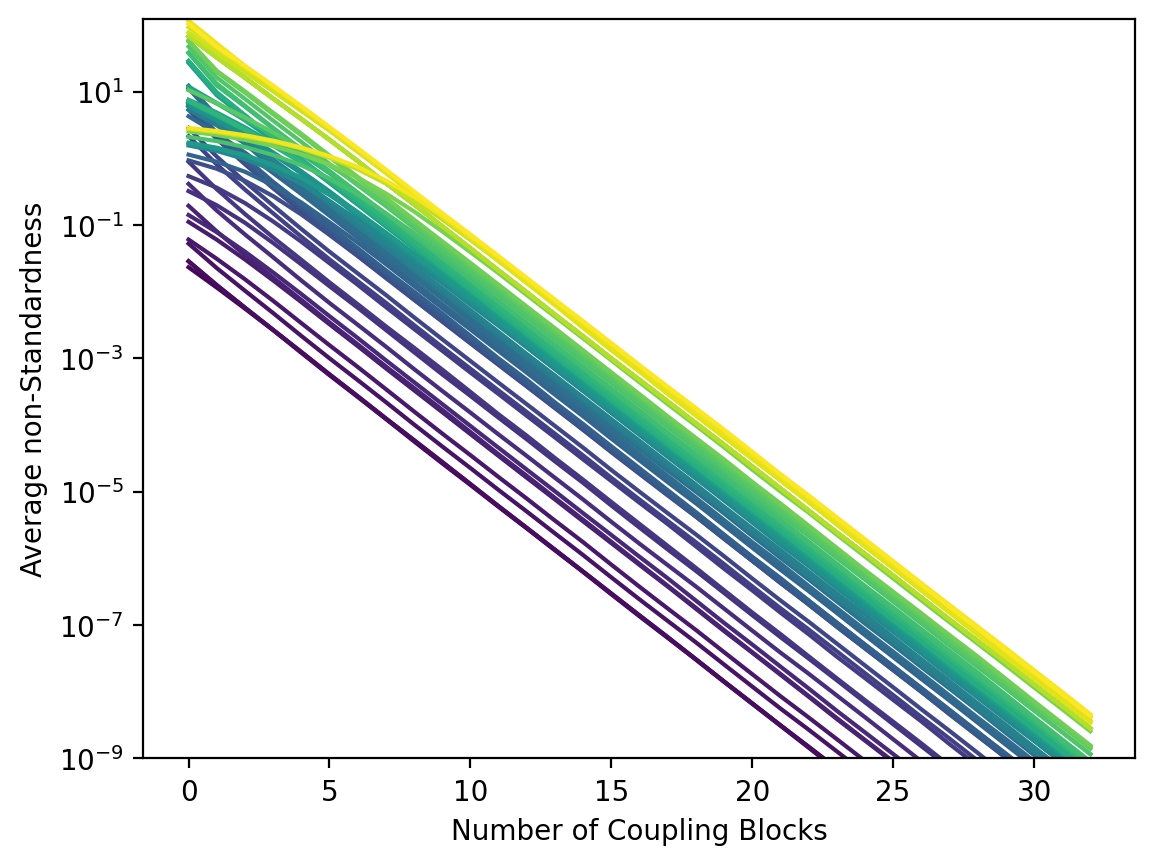

In [49]:
which = np.random.default_rng(4231).permutation(ev.shape[0])[:64]

losses = -np.linalg.slogdet(covs)[1] / 2
losses_ma = np.ma.masked_where(np.broadcast_to(losses.mean(1, keepdims=True) < 1e-10, losses.shape), losses)


def loss_by_layer():
    losses_selected = losses[which]
    order = np.argsort(losses_selected.mean(1)[:, 10])

    plt.gca().set_prop_cycle(
        plt.cycler('color',
                   plt.get_cmap(cmaps['standard'])(np.linspace(0, 1, losses_selected.shape[0])))
    )

    plt.plot(losses_selected[order].mean(1).T)
    plt.ylim(bottom=1e-9)
    plt.yscale("log")

    plt.ylabel("Average non-Standardness")
    plt.xlabel("Number of Coupling Blocks")


loss_by_layer()

In [50]:
loss_ratios = losses_ma[:, :, 1:] / losses_ma[:, :, :-1]

evs = np.linalg.eigvalsh(covs)
# To speed up computation, set to a small value (e.g. 1). This usually has no effect on outcome
unitary_count = None
unitary_bounds = cb.compute_unitary_bound(evs[:, :unitary_count], dim_a, prec=1000, pbar=True) / losses_ma[:, :unitary_count]
var_max_bounds = cb.compute_var_max_bound(evs, dim_a) / losses_ma
loss_bounds = cb.compute_loss_only_bound(evs, dim_a) / losses_ma

  0%|          | 0/2257 [00:00<?, ?it/s]

In [51]:
def masked_quantile(masked_array, *args, **kwargs):
    return np.nanquantile(np.ma.filled(masked_array, np.nan), *args, **kwargs)

/home/felix/miniconda3/envs/optimal-transport/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


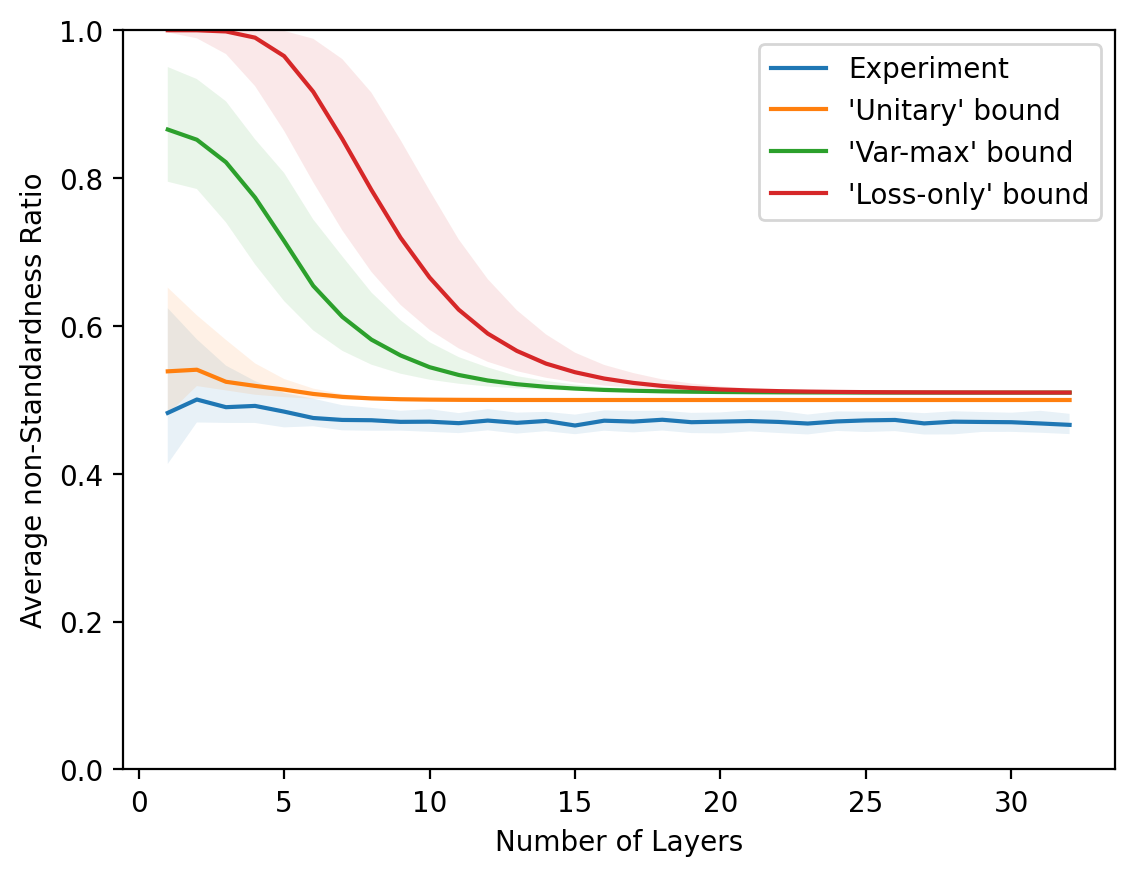

In [52]:
def rate_by_layer():
    for i, (name, metric) in enumerate([
        ("Experiment", loss_ratios),
        ("'Unitary' bound", unitary_bounds[..., :-1]),
        ("'Var-max' bound", var_max_bounds[..., :-1]),
        ("'Loss-only' bound", loss_bounds[..., :-1])
    ]):
        # Median
        median = np.nanmedian(np.nanmedian(metric, 1), 0)
        layers = np.arange(metric.shape[-1]) + 1
        plt.plot(layers, median, label=name)

        # IQR
        q = .25
        q_low = masked_quantile(metric.reshape(-1, metric.shape[-1]), q, 0)
        q_high = masked_quantile(metric.reshape(-1, metric.shape[-1]), 1 - q, 0)
        plt.fill_between(layers, q_low, q_high, alpha=.1)

    plt.legend()
    plt.ylim(0, 1)
    plt.ylabel("Average non-Standardness Ratio")
    plt.xlabel("Number of Layers")


rate_by_layer()

## Compose results

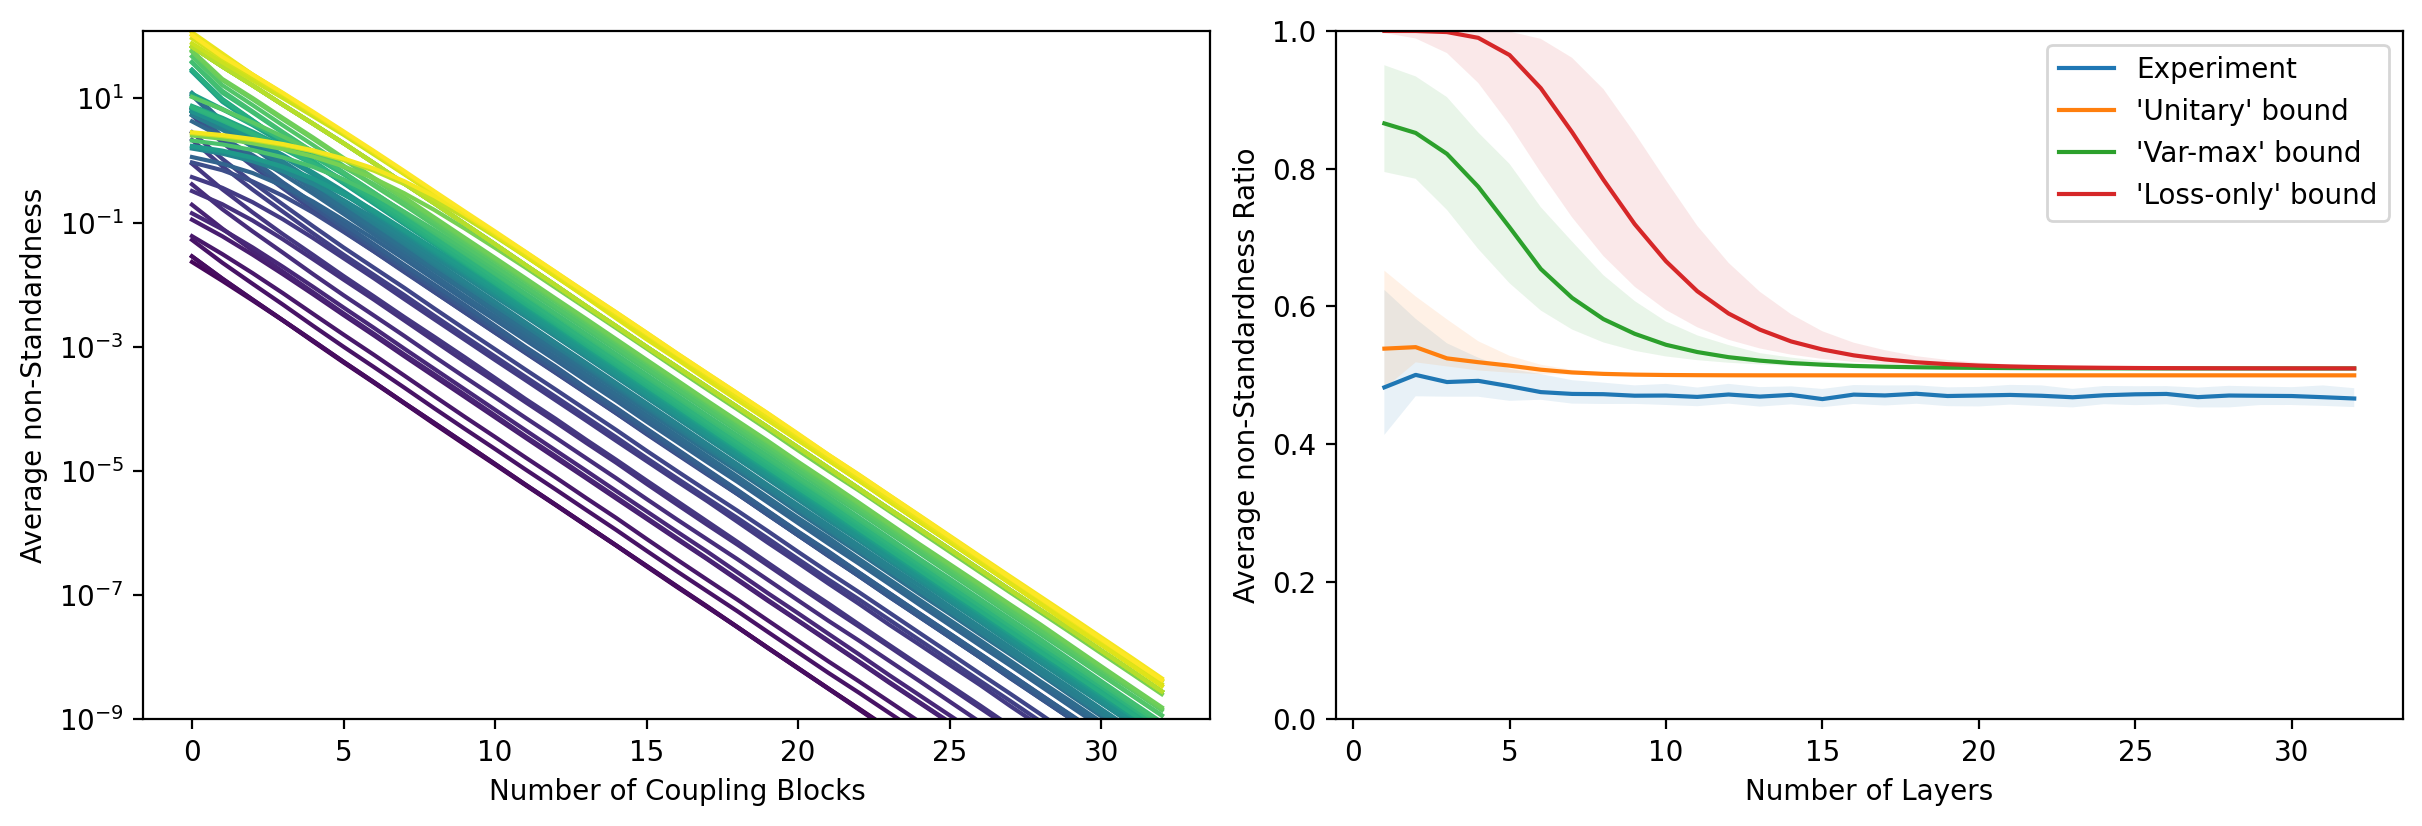

In [53]:
ax1, ax2 = plt.subplots(1, 2, figsize=(fig_width, fig_width / 3), constrained_layout=True)[1]

plt.sca(ax1)
loss_by_layer()

plt.sca(ax2)
rate_by_layer()

cb.vis.savefig(fig_dir / "multi-layer-bounds.pdf", bbox_inches="tight")